In [35]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
%matplotlib inline
import copy

## Mathmatic Functions

In [2]:
# centers the opinion vector around 0
def mean_center(op, n1):
    ones = np.ones((n1, 1))
    x = op - (np.dot(np.transpose(op),ones)/n1) * ones
    return x

# compute number of edges, m
def num_edges(La, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and La[i,j] < 0:
                m += 1            
    return m


In [3]:
# # maximizing polarization only: \bar{z}^T \bar{z}   
def obj_polarization(G1, s1, s2, n1):
    np.set_printoptions(precision=5)
    z1 = equilibrium(n1,s1, g, h, G1, beta,gamma)
#     z = np.concatenate((z1,s2))
    op_mean = mean_center(z1, n1)
    return np.dot(np.transpose(op_mean), op_mean)[0,0] 

In [4]:
# Calculate innate polarization
def obj_innate_polarization(op, n):  
    np.set_printoptions(precision=5)
    op_mean = mean_center(op, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]



In [5]:
# Parameters for the network
n = 22   # number of nodes in the network
r = 1/11  # percent of info souce in the network
n1 = int(n*(1-r))

np.set_printoptions(precision=3)

## Generating Network
### 1. Make Innate opinion

In [6]:
##create two set of weights connected with density 1) inviduals  2) individual & informaton Source
c1 = np.sort(np.random.choice(n1, n1, replace=False)) #assume (1-r) are individuals
print('c1')
print(c1)
l1 = len(c1)

c1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [7]:
def make_innat_opinions(n, c1): #(n1, n2):
    
    # Make list of ind innate opinion to define info source opinion
    innat_s1 = np.random.uniform(low=0.0, high=1.0, size=int(n*(1-r)))    #individual's innate opinion 

    s1 = np.zeros((round((1-r)*n), 1))
    
    idx1 = 0
    for i in range(len(s1)):
        s1[i] = innat_s1[idx1]  #set innate opinion for ind.
        idx1 += 1

    print('s1')
    print(s1)

    # Make info souce opinion
#     h = np.random.uniform(low=max(s1), high=1.0, size=1)
#     g = np.random.uniform(low=0.0, high=min(s1), size=1)
    h = np.eye(1)
    g = np.zeros((1,1))

    s2 = np.concatenate((g, h),axis=0)
#     print('s2')
#     print(s2)

    # Make opinion list of both info source and agents   
    
    s = np.zeros((n, 1))
    idx1 = 0
    idx2 = 0

    for i in range(len(s)):
        if i in c1:
            s[i] = s1[idx1]
            idx1 += 1
        else:
            s[i] = s2[idx2]
            idx2 += 1    

#     print('s')
#     print(s)

  
    return (s1, h, g, s2, s)

### 2. Make Confirmation Bias Adjacency Matrices

In [8]:
np.set_printoptions(precision=4)

In [9]:
### Prepare for create adjacent matrix
p1 = 0.5 # density within ind.
p2 = 0 # density of edges between Info Source and Indivisuals

pre_weights1 = scipy.sparse.random(1, int(0.5*l1*(l1 - 1)), density=p1).A[0] 
weights1 = pre_weights1/25


# print("weight1")
# print(weights1)
# weights1.shape

# b = weights2.round()  #generate a binary array to indicate the connection between ind. and inf. source 
                          #without consider the innate opinions, just based on the edges between info source and ind.


In [10]:
np.set_printoptions(precision=3)

In [11]:
# create n x n adjacency matrix with existing init_G
G1 = np.zeros((n1, n1))
    
## Assign edges between ind to ind 
idx = 0
for i in c1:
    for j in c1:
            if i == j:
                G1[i][j] =0
                continue
            elif i < j:
                G1[i][j] = weights1[idx]
                idx += 1
#                 print(idx)
#                 print (G1[i][j])
            else:
                G1[i][j] = G1[j][i]
print("G for agents completed!")
# print(G1)


G for agents completed!


### 3. Network Visualization

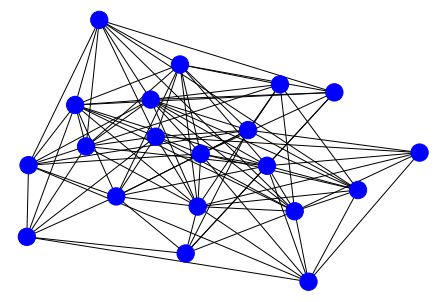

<Figure size 1800x1800 with 0 Axes>

In [12]:
La = scipy.sparse.csgraph.laplacian(G1, normed=False)

nxG = nx.from_numpy_matrix(G1)

color_map = []
for node in nxG:
    if node in c1:
        color_map.append('Blue')
    else: 
        color_map.append('Red')  

#nxG1 = nx.DiGraph(G)
nx.draw(nxG, node_color=color_map, with_labels=False)
plt.figure(figsize=(25, 25))
plt.show()

In [13]:
## calculate Max row sum & column sum of agent' G --> result from beta gamma value

rowsum_ij = np.sum(G1,1)
max_rowsum_ij = max(rowsum_ij)
# print(rowsum_ij)
# print(max_rowsum_ij)
colsum_ij = np.sum(G1, axis=0)
max_colsum_ij = max(colsum_ij)
# print(colsum_ij)
# print(max_colsum_ij)

threshold = 1- max(max_rowsum_ij,max_colsum_ij)
print("Beta reference value less than")
print(threshold/2)
print('Gamma reference value less than')
print(threshold/4)

Beta reference value less than
0.37077036795618956
Gamma reference value less than
0.18538518397809478


#### ---> here to update confirmation bias network

In [44]:
## assumptions: 1) beta > gamma >0    2) 1 - max{rowsum, colsum} >= max{2beta, 4gamma}

gamma = 0.00
beta = 0.30   # the average weight between agents
# check beta gamma are qualify or not
pipi = max(2*beta, 4*gamma)
# print(pipi)

ss = max(max_rowsum_ij, max_colsum_ij)
# print(ss)

xixi = pipi + ss
print("Should be less than 1:")
print (xixi)

Should be less than 1:
0.8584592640876207


In [45]:
np.set_printoptions(precision=4)
(s1, g, h, s2, s) = make_innat_opinions(n, c1)
store = s1
s1 = store 
op = s1

#Test innate polarization

y = mean_center(s1,n1)
# print(y)
innat_pol = np.dot(np.transpose(y), y)[0,0] 
print('innate_polarization')
print(innat_pol)

s1
[[0.2287]
 [0.835 ]
 [0.5246]
 [0.6714]
 [0.9052]
 [0.6339]
 [0.1348]
 [0.6811]
 [0.6485]
 [0.3934]
 [0.3842]
 [0.9886]
 [0.0614]
 [0.3515]
 [0.3006]
 [0.6512]
 [0.9813]
 [0.9608]
 [0.1427]
 [0.5185]]
innate_polarization
1.6489968577677017


In [16]:
## Test to see if Rowsum and column sum in final G is less than 0 
# rowsum = np.sum(G1,1)
# max_rowsum = max(rowsum)
# print(rowsum)
# print(max_rowsum)
# colsum = np.sum(G1, axis=0)
# max_colsum = max(colsum)
# print(colsum)
# print(max_colsum)

### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [53]:
#     ##calculate equlibriua manually (Successful!!!)
def equilibrium(n1,opinion,g,h,G1,beta,gamma): 
    ## Cki are the determinate parameter indicate if info. source influence the agent or not
    c1i = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    c2i = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    C1 = np.diag(c1i, k=0)
    C2 = np.diag(c2i, k=0)
    # print(s1)
    R1 = C1*opinion
    R2 = C2*opinion
    I = np.eye(n1)
    Ematrix = I - G1 + gamma*(R2 - R1 + h*C1 - g*C2)
    Ematrix_inverse = np.linalg.inv(Ematrix)
    rowsum = np.sum(G1,1)
    rowsumm_atrix = np.zeros((n1, n1))
    for i in range(n1):
        rowsumm_atrix[i,i] = rowsum[i]
    addMatrix = I - rowsumm_atrix - (C1+C2)*beta + (C1*h + C2*g)*gamma
    A = np.matmul(Ematrix_inverse,addMatrix)
    Vector_A = (c1i*h + c2i*g)*beta + (c2i*g**2-c1i*h**2)*gamma
    # print(np.shape(Vector_A))
    trans_Vector_A = Vector_A.transpose()
    # print(np.shape(trans_Vector_A))
    L = np.matmul(Ematrix_inverse, trans_Vector_A)
    # print(L)
    z1 = np.matmul(A,s1) + L
    
#     print("equilibrium opinion")
#     print(z1)
    return z1

In [54]:

print(C1+C2)

print(beta)
# print((C1+C2)*beta)

0
0.3


In [55]:
np.set_printoptions(precision=4)

#Test obj_innate_polarization function 
#No Op Change Equilibriua of Stand
z1  = equilibrium(n1, s1, g,h,G1,beta,gamma)
print('check: Equilibrium op should NOT have any negative value')
print(z1)

y = mean_center(s1,n1)
# print(y)
innat_pol = np.dot(np.transpose(y), y)[0,0] 
print('Innate_polarization:')
print(innat_pol)

# Test equilibrium polarization
equ_pol = obj_polarization(G1, s1, s2, n1)
print('Equilibrium polarization:')
print(equ_pol)

di = innat_pol - equ_pol
print("Difference:")
print(di)
print(z1-s1)

check: Equilibrium op should NOT have any negative value
[[0.2694]
 [0.7892]
 [0.5332]
 [0.6489]
 [0.8532]
 [0.6289]
 [0.2403]
 [0.6322]
 [0.6344]
 [0.4267]
 [0.4049]
 [0.943 ]
 [0.1519]
 [0.3931]
 [0.322 ]
 [0.6231]
 [0.881 ]
 [0.9299]
 [0.1896]
 [0.5146]]
Innate_polarization:
1.6489968577677017
Equilibrium polarization:
1.170211116090555
Difference:
0.4787857416771466
[[ 0.04065]
 [-0.04575]
 [ 0.00856]
 [-0.02248]
 [-0.05198]
 [-0.00505]
 [ 0.10552]
 [-0.0489 ]
 [-0.01406]
 [ 0.03332]
 [ 0.02073]
 [-0.04563]
 [ 0.09051]
 [ 0.04156]
 [ 0.02141]
 [-0.02809]
 [-0.10027]
 [-0.03095]
 [ 0.04683]
 [-0.00389]]


#### Perfect Network Generation Above
_________________________________________________________________________________________________________________


In [56]:
np.set_printoptions(precision=4)
print('Innate opinion in the game')
print(op)

Innate opinion in the game
[[0.2287]
 [0.835 ]
 [0.5246]
 [0.6714]
 [0.9052]
 [0.6339]
 [0.1348]
 [0.6811]
 [0.6485]
 [0.3934]
 [0.3842]
 [0.9886]
 [0.0614]
 [0.3515]
 [0.3006]
 [0.6512]
 [0.9813]
 [0.9608]
 [0.1427]
 [0.5185]]


## 4. Maximize & Minimizer's Behavior

###     Maximizer's Choice

Innate greedy algorithm (polarization):

For each $i$ from $1$ to $k$, we choose $v_i$ such that:

$$v_i = argmax_{v \in V - \hat{s}} \max \left(\bar{s}_1^T \bar{s}_1, \bar{s}_0^T \bar{s}_0 \right) $$

In [57]:
# determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization 
def maximize_equi_polarization(op, n1, v):
    
    innat_equi_por = obj_polarization(G1, op, s2, n1)
    temp = op[v, 0]
    por_arr = np.zeros(11)
#     print(por_arr)
    
    max_opi_option = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    # objective if set opinion to 0, 0.1, ..., 1.0
    i = 0
    for new_op in max_opi_option:
#         print('change op to '+ str(i/10))
        
        op[v, 0] = new_op
        por_arr[i] = obj_polarization(G1, op, s2, n1)
#         print(por_arr[i])
        i = i + 1
        op[v, 0] = temp
#     print(por_arr)
    
#     z = equilibrium(n1,s1,g,h,G1,beta,gamma)
    
    
    maxmize_op = np.argmax(por_arr)/10
    max_por = np.max(por_arr)
 
#     print('new_op', 'innat_equi_por', 'max_por')
#     print(maxmize_op, innat_equi_por, max_por)

    return (maxmize_op, innat_equi_por, max_por)

In [58]:
(new_op, innat_equi_por, max_por) =  maximize_equi_polarization(op, n1, v)

NameError: name 'v' is not defined

In [59]:
def choose_max_vertex(op, n1, min_touched):
    # iterate over all the vertices that have not yet been changed
    vertices = np.where((op != 0.0) & (op != 1.0))
    # current best vertex, its opinion {0, 1}, "innate" objective, and objective
    
    innat_equi_por = obj_polarization(G1, op, s2, n1)
#     print("innate equi por to compare")
#     print(innat_equi_por)
    
    champion = (None, None, 0, innat_equi_por)

    for v in vertices[0]:
        print('Max start with agent '+ str(v) )
        if v not in min_touched:
            (changed_opinion, innat_equi_por, max_por) = maximize_equi_polarization(op, n1, v)

            if max_por >= champion[3]:
                champion = (v, changed_opinion, innat_equi_por, max_por)

    return (champion)


In [60]:
max_champion = choose_max_vertex(op, n1, min_touched)
print('v', 'changed_opinion', 'innate_obj', 'obj')
print (max_champion)


Max start with agent 0
Max start with agent 1
Max start with agent 2
Max start with agent 3
Max start with agent 4
Max start with agent 5
Max start with agent 6
Max start with agent 7
Max start with agent 8
Max start with agent 9
Max start with agent 10
Max start with agent 11
Max start with agent 12
Max start with agent 13
Max start with agent 14
Max start with agent 15
Max start with agent 16
Max start with agent 17
Max start with agent 18
Max start with agent 19
v changed_opinion innate_obj obj
(3, 0.0, 1.170211116090555, 1.3774834307040718)


### Minimizer's Choice


In [61]:
# print('Here s1 and op is not changed Yet')
# print(s1)

# op = s1
# print(op)

In [62]:
# determines if a given vertex should be set to zero or one, all else equal
def minimize_opinion(op, s2, n1, v):
    
    innat_equi_por = obj_polarization(G1, op, s2, n1)
    # save original value of innate opinion
    temp = op[v,0]

    # minimizer's options
    min_opi_option = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    obj = np.zeros(11)

    # objective if set opinion to 0, 0.1, ..., 1.0
    i = 0
    for new_op in min_opi_option:
        op[v, 0] = new_op
        obj[i] = obj_polarization(G1, op, s2, n1)
#         print('change op to '+ str(i/10))
#         print(obj[i])
        i = i + 1
        # restore original opinion
        op[v, 0] = temp


    minimize_op = np.argmin(obj)/10
    min_pol = np.min(obj)
    
#     print('new_op', 'innat_equi_por', 'min_pol')
#     print(minimize_op, innat_equi_por, min_pol)
    
    # pick the opinion value that yields bigger objective function value
    return (minimize_op, innat_equi_por, min_pol)

In [63]:
def choose_min_vertex(op, n1, max_touched):
    # iterate over all the vertices that have not yet been changed
    vertices = np.where((op != 0.0) & (op != 1.0))
    # current best vertex, its opinion {0, 1}, "innate" objective, and  current best objective

    innat_equi_por = obj_polarization(G1, op, s2, n1)
#     print("innate equi por to compare")
#     print(innat_equi_por)

    champion = (None, None, 0, innat_equi_por)

    for v in vertices[0]:
        if v not in max_touched:
            print('Min start with agent '+ str(v) )
            (minimize_op, innat_equi_por, min_pol) = minimize_opinion(op, s2, n1, v)  

            if min_pol <= champion[3]:
                champion = (v, minimize_op, innat_equi_por, min_pol)

    return (champion)

In [64]:
max_touched = []
### use new equilibrium
min_champion = choose_min_vertex(op, n1, max_touched)
print('v', 'changed_opinion', 'innate_obj', 'obj')
print (min_champion)

Min start with agent 0
Min start with agent 1
Min start with agent 2
Min start with agent 3
Min start with agent 4
Min start with agent 5
Min start with agent 6
Min start with agent 7
Min start with agent 8
Min start with agent 9
Min start with agent 10
Min start with agent 11
Min start with agent 12
Min start with agent 13
Min start with agent 14
Min start with agent 15
Min start with agent 16
Min start with agent 17
Min start with agent 18
Min start with agent 19
v changed_opinion innate_obj obj
(12, 0.6, 1.170211116090555, 0.9948956041585509)


### Testing maxmizer's behavior

In [65]:
# max_champion = choose_max_vertex(op, n1)
# (v, changed_opinion, innate_obj, obj) = max_champion

# print('__________________________________')
# print("Maximizer find its target agent!")
# print('v', 'changed_opinion', 'innate_obj', 'obj')
# print(max_champion)

# #Store innate_op of the selected vertex
# old_opinion = op[v, 0]

# ##### change the agent's opinion
# op[v,0] = max_champion[1]
# ## check if agent's opinionis is changed or not
# print("Maximizer changed agent" + str(v+1) +" opinion " + str(old_opinion) + " to "+ str(max_champion[1]))
# #         print(op)



In [66]:
# ### opinion changed ---> find the equilibrium opinion 
# equi_opi_max = equilibrium(n1,op,g,h,G1,beta,gamma) #Take the equilibrium opinion after maxmizer's operation
# max_input = equi_opi_max 
# op_mean = mean_center(max_input, n1) # equi. polarization
# por_max = np.dot(np.transpose(op_mean), op_mean)[0,0]
# print("Network reaches equilibrium Polarization: " + str(por_max))
# # print("Equilibrium Opinion" + str(max_input))

# print('Minimizer start with')
# print (max_input)

In [67]:
def random_play(s1,n1):
    
    op = copy.copy(s1)
    max_opi_option = [0, 1.0]
    
    v = random.randint(0,n1-1)
#     print(v)
    new_op = random.randint(0, 1)
#     print(new_op)
    
    # Store old opinion
    old_opinion = op[v,0]
    
    #update the opinion
    op[v,0] = new_op 
#     print('Only 1 opinion changed')
#     print(op)
    print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    por = obj_polarization(G1, op, s2, n1) 
    ### opinion changed ---> find the equilibrium opinion 


    equi = equilibrium(n1,op,g,h,G1,beta,gamma) #Take the equilibrium opinion after maxmizer's operation
    
    
    #restore op
    op[v] = old_opinion
    print("Network reaches equilibrium Polarization: " + str(por))
#     print('Should be restored')
#     print(op)
    return (v, new_op, por)





In [68]:
####Op has been updated by maximizer, so minimizer react to the innate op after that
def minimizer_play(s1,v1,max_opinion,n1, max_touched): 
    
    op = copy.copy(s1)
    #update innat opinion 
    op[v1,0] = max_opinion
    print('_______________________')
    print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)
    
    min_champion = choose_min_vertex(op, n1, max_touched)
    (v2, min_opinion, innat_equi_por, min_pol) = min_champion
    
    if v2 == None:
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")
#         print('v2', 'changed_opinion', 'innate_obj', 'obj')
#         print(v2, min_opinion, innat_equi_por, min_pol)
        #Store innate_op of the min_selected vertex
        old_opinion_min = op[v2,0]
        ##### change the agent's opinion
        op[v2,0] = min_opinion   #-------------------------------------------------> store minimize strategy


        print("    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))

#         print("Network reaches equilibrium Polarization: " + str(min_pol))
#         print('2 opinion changed')
#         print(op)


        #restore op
#         op[v1] = old_opinion_min
#         op[v2] = old_opinion_max
        #alternative way to restore
#         op = reset 
#         print("Should be innate op")
#         print(op)
    return (v2,min_opinion, min_pol)

In [69]:
def maximizer_play(s1,v2,min_opinion,n1,min_touched): 
    op = copy.copy(s1)
    #update innat opinion 
    op[v2,0] = min_opinion
#     print('Only 1 opinion changed')
#     print(op)
    

    max_champion = choose_max_vertex(op, n1, min_touched)
    (v1, max_opinion, innate_obj, max_pol) = max_champion

    if v1 == None:
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
#         print('v1', 'changed_opinion', 'innate_obj', 'obj')
#         print(max_champion)

        #Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]
        ##### change the agent's opinion
        op[v1,0] = max_opinion
        ## check if agent's opinionis is changed or not
        print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
#         print("Network reaches equilibrium Polarization: " + str(max_pol))
#         print('2 opinion changed')
#         print(op)
        #restore op
#         op[v1] = old_opinion_min
#         op[v2] = old_opinion_max
        
#         #alternative way to restore
#         op = reset 
        
#         print("Should be innate op")
#         print(op)

    return(v1, max_opinion, max_pol)

In [70]:
# # # Testing block to see if player operate properly
# (max_input, por_max) =  maximizer_play(op,n1)
# # result =  minimizer_play(max_input, n1)


# Equilibrium

In [71]:
print(op)

[[0.22873]
 [0.83499]
 [0.52459]
 [0.67137]
 [0.90522]
 [0.63393]
 [0.13476]
 [0.68113]
 [0.64847]
 [0.39341]
 [0.38416]
 [0.98863]
 [0.06137]
 [0.35151]
 [0.30062]
 [0.6512 ]
 [0.98129]
 [0.96081]
 [0.14272]
 [0.51854]]


# Game Start!

In [72]:

Flag = 0
i = 0
max_touched = []
min_touched = []
print('min_touched')
print(min_touched)
min_pol = 0

# Game start from maximizer random play
print('Maximizer random selection')
(v1, max_opinion, max_pol) = random_play(op,n1)
max_touched.append(v1)
print("v1 max_opinion")
print(v1, max_opinion)

while Flag == 0: 
    i = i + 1
    print("Game " + str(i))
    print("_____________________")
    
#     a = round(equi_min,4)
#     b = round(equi_max,4)
    if max_pol == min_pol:
        print("Reached PURE Nash Equilibrium at game"+ str(i) + " Equi_Por:" + str(max_pol) )
        print('Maximizer')
        print("   changed "+"Agent" + str(v1) +" 's opinion to "+ str(max_opinion))
        print('Minimizer')
        print("   changed "+"Agent" + str(v2) +" 's opinion to "+ str(min_opinion))
        break

    ############################## maximizer play  
    else:
        (v2, min_opinion, min_pol) = minimizer_play(op,v1,max_opinion,n1, max_touched)
        min_touched.append(v2)
        print('min_touched')
        print(min_touched)
        print('max_touched')
        print(max_touched)
        (v1, max_opinion, max_pol) = maximizer_play(op,v2,min_opinion,n1,min_touched)
        max_touched.append(v1)
        print('min_touched')
        print(min_touched)
        print('max_touched')
        print(max_touched)



min_touched
[]
Maximizer random selection
    Agent19 's opinion 0.5185389856148027 changed to 0
Network reaches equilibrium Polarization: 1.170211116090555
v1 max_opinion
19 0
Game 1
_____________________
_______________________
Minimizer Play
Min start with agent 0
Min start with agent 1
Min start with agent 2
Min start with agent 3
Min start with agent 4
Min start with agent 5
Min start with agent 6
Min start with agent 7
Min start with agent 8
Min start with agent 9
Min start with agent 10
Min start with agent 11
Min start with agent 12
Min start with agent 13
Min start with agent 14
Min start with agent 15
Min start with agent 16
Min start with agent 17
Min start with agent 18
                                
Minimizer finds its target agent:
    Agent18 's opinion 0.14272387355997418 changed to 0.0
min_touched
[18]
max_touched
[19]
Max start with agent 0
Max start with agent 1
Max start with agent 2
Max start with agent 3
Max start with agent 4
Max start with agent 5
Max start wi